In [356]:
import pandas as pd 
from datetime import datetime


In [357]:
!pip install lightgbm 

In [358]:
train_set = pd.read_csv('Bases/train.csv')
test_set = pd.read_csv('Bases/test.csv')

In [359]:
df = train_set.append(test_set)
print(df.shape)
df.head(2)

(1309, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


# Data Treatment
---

In [360]:
#df.isna().sum()
df['Embarked'] = df['Embarked'].fillna("S") # the most massive part is "S"
df['Cabin'] = df['Cabin'].fillna("U") # Coletar informações sobre Cabin
df['Cabin'] = df['Cabin'].str[0] # fazer mais features com Cabin
df['has_age'] = df['Age'].isna() == False
df['Age'] = df['Age'].fillna(df['Age'].mean()) # Fazer um mini modelo com lgbm regressor para tentar prever e diminuir o RMSE
df['Fare'] = df['Fare'].fillna(df['Fare'].mean()) # Here we can use a groupby that would be better


df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,has_age
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,U,S,True
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C,True


In [361]:

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
to_labeling = ['Cabin','Embarked','Sex']
df[to_labeling] = df[to_labeling].apply(label_encoder.fit_transform)
df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,has_age
0,1,0.0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,8,2,True
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,2,0,True


# Feature Engineering
---

## Categorial feature Engineering
---

In [362]:
import itertools
cat_features = ['Cabin','Embarked','Sex','Pclass']
for col_x,col_y in itertools.combinations(cat_features,2):
    df[col_x+"_"+col_y] = df[col_x].astype(str) + "_" + df[col_y].astype(str)
    df[col_x+"_"+col_y] = label_encoder.fit_transform(df[col_x+"_"+col_y])
df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,has_age,Cabin_Embarked,Cabin_Sex,Cabin_Pclass,Embarked_Sex,Embarked_Pclass,Sex_Pclass
0,1,0.0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,8,2,True,19,15,14,5,8,5
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,2,0,True,4,4,2,0,0,0


In [363]:
import category_encoders as ce
# Create the encoder
count_enc = ce.CountEncoder(cols=cat_features)
count_encoded = count_enc.fit_transform(df[cat_features]).reset_index(drop=True)
df = df.reset_index(drop=True).join(count_encoded.add_suffix("_count"))
df.head(2)

C:\ProgramData\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Cabin_Embarked,Cabin_Sex,Cabin_Pclass,Embarked_Sex,Embarked_Pclass,Sex_Pclass,Cabin_count,Embarked_count,Sex_count,Pclass_count
0,1,0.0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,...,19,15,14,5,8,5,1014,916,843,709
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,...,4,4,2,0,0,0,94,270,466,323


## Numerical feature Engineering
---

In [364]:
num_features = ["Pclass","Sex",'Age',"SibSp","Parch","Fare"]
for col_x,col_y in itertools.combinations(num_features,2):
    df[col_x+"_"+col_y] = (df[col_x]+1)*(df[col_y]+1)
df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Sex_Age,Sex_SibSp,Sex_Parch,Sex_Fare,Age_SibSp,Age_Parch,Age_Fare,SibSp_Parch,SibSp_Fare,Parch_Fare
0,1,0.0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,...,46.0,4,2,16.5000,46.0,23.0,189.7500,2,16.5000,8.2500
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,...,39.0,2,1,72.2833,78.0,39.0,2819.0487,2,144.5666,72.2833


In [365]:
df['Family_size'] = df["SibSp"] + df["Parch"] + 1
df['Fare/Family'] = df['Fare']/df['Family_size']

######## Names
df['name_treatment'] = df['Name'].str.split(", ",expand=True).loc[:,1].str.split(" ",expand=True).loc[:,0]
df['name_treatment'] = label_encoder.fit_transform(df['name_treatment'])
count_enc = ce.CountEncoder(cols=['name_treatment'])
df['name_treatment_count'] = count_enc.fit_transform(df['name_treatment'])
# for mean_encoding
count_enc = ce.CountEncoder()
df['name_family'] = count_enc.fit_transform(df['Name'].str.split(", ",expand=True).loc[:,0])

######## Tickets
# df['Ticket_first_letter'] = label_encoder.fit_transform(df['Ticket'].str[0])
# count_enc = ce.CountEncoder()
# df['Ticket_first_letter_freq'] = count_enc.fit_transform(df['Ticket_first_letter'])
# #drop
# df['has_unique_ticket'] = df['Ticket'].map(df['Ticket'].value_counts() == 1)



df.drop(['Name','Ticket'],axis=1,inplace=True) # create features with these explore the maximum


C:\ProgramData\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


# Train_test_Split
---

In [366]:
data_train = df[df['PassengerId'].isin(train_set['PassengerId'])].copy()
data_train['Survived'] = data_train['Survived'].astype(int)
data_train = data_train.set_index('PassengerId')
feature_cols = data_train.columns.drop('Survived')
##################3
data_test = df[df['PassengerId'].isin(test_set['PassengerId'])].copy()
data_test = data_test.set_index('PassengerId')


# Feature Selection
---

In [367]:
# feature_importance = pd.DataFrame(best_model.feature_importances_,index=best_model.feature_name_,columns=['importância']).sort_values('importância',ascending=False)
# feature_importance = feature_importance/feature_importance.max()
# import seaborn as sns 
# feature_importance.plot(kind='bar')
from lightgbm import LGBMClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
from sklearn.model_selection import cross_val_score, GridSearchCV

In [368]:
from sklearn.feature_selection import RFECV


model = LGBMClassifier(random_state=7)
selecionar_rfe = RFECV(estimator=model, min_features_to_select=5, cv=cv, scoring='accuracy')
selecionar_rfe.fit(data_train[feature_cols], data_train['Survived'])
print("Selecionadas")
print("Número de melhores features:",selecionar_rfe.n_features_)
print(data_train[feature_cols].columns[selecionar_rfe.support_])

Selecionadas
Número de melhores features: 31
Index(['Age', 'Fare', 'Cabin', 'Embarked', 'has_age', 'Cabin_Embarked',
       'Cabin_Sex', 'Cabin_Pclass', 'Embarked_Sex', 'Embarked_Pclass',
       'Sex_Pclass', 'Cabin_count', 'Pclass_count', 'Pclass_Age',
       'Pclass_SibSp', 'Pclass_Fare', 'Sex_Age', 'Sex_SibSp', 'Sex_Parch',
       'Sex_Fare', 'Age_SibSp', 'Age_Parch', 'Age_Fare', 'SibSp_Parch',
       'SibSp_Fare', 'Parch_Fare', 'Family_size', 'Fare/Family',
       'name_treatment', 'name_treatment_count', 'name_family'],
      dtype='object')


In [369]:
import matplotlib.pyplot as plt

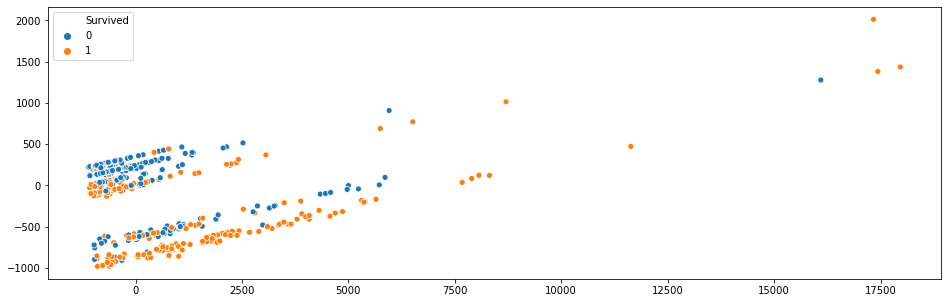

In [370]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
df_visual = pca.fit_transform(data_train[feature_cols])
plt.figure(figsize=(16,5))
sns.scatterplot(x=df_visual[:,0],y=df_visual[:,1],hue=data_train['Survived'])

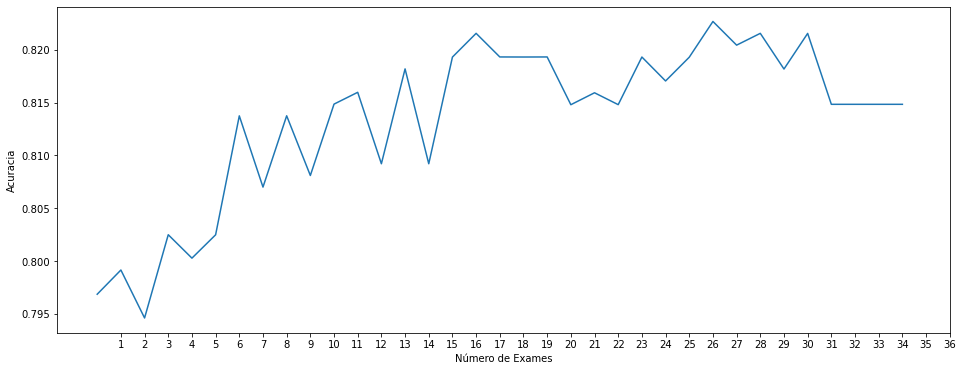

In [371]:
#feature_cols = data_train[feature_cols].columns[selecionar_rfe.support_]
plt.figure(figsize=(16,6))
plt.xlabel("Número de Exames")
plt.ylabel("Acuracia")
plt.plot(selecionar_rfe.grid_scores_)
plt.xticks(range(1,len(selecionar_rfe.grid_scores_)+2))
#plt.grid()
plt.show()

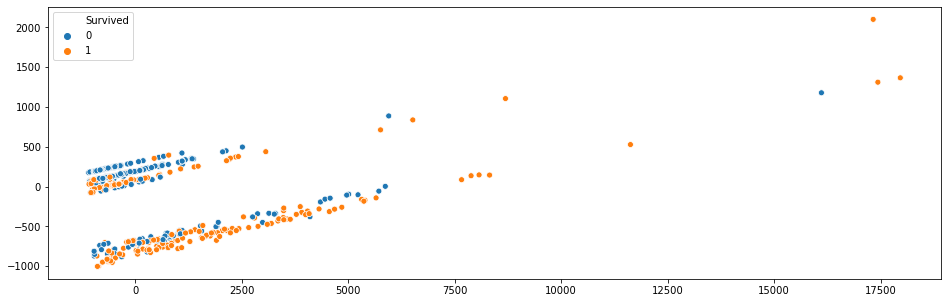

In [372]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
df_visual = pca.fit_transform(data_train[data_train[feature_cols].columns[selecionar_rfe.support_]])
plt.figure(figsize=(16,5))
sns.scatterplot(x=df_visual[:,0],y=df_visual[:,1],hue=data_train['Survived'])

# Hyperparameter Tuning
---

In [373]:

import numpy as np 
model = LGBMClassifier(random_state=7)
tuning_params = {
    'num_leaves': [4,8,16,32],
    'n_estimators':[100,400,500,600],
    'max_depth':[-1,2,4,8,16],
    'learning_rate':[0.01,0.1],
    'reg_lambda':[0.7,1,1.5,2]
}

grid_model = GridSearchCV(model,param_grid=tuning_params,scoring='accuracy',n_jobs=-1,cv=cv,return_train_score=True)
grid_model.fit(data_train[feature_cols], data_train['Survived'])
print("Fitado!")

Fitado!


# Validation
---

In [374]:
pd.DataFrame(grid_model.cv_results_).sort_values('rank_test_score').head(5)[['mean_train_score','mean_test_score']]

,mean_train_score,mean_test_score
466,0.932660,0.843996
530,0.932660,0.843996
594,0.932660,0.843996
338,0.932660,0.843996
531,0.928171,0.839506


In [375]:
print("melhores parametros: ",grid_model.best_params_)
print("melhor score: ",grid_model.best_score_)
best_model = grid_model.best_estimator_
n_scores = cross_val_score(best_model, data_train[feature_cols], data_train['Survived'], scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f +- (%.3f)' % (np.mean(n_scores), np.std(n_scores)))


melhores parametros:  {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 400, 'num_leaves': 4, 'reg_lambda': 1.5}
melhor score:  0.8439955106621774
Accuracy: 0.844 +- (0.016)


In [350]:
# from sklearn.dummy import DummyClassifier
# dumm_clf = DummyClassifier()
# dummy_clf = DummyClassifier(strategy="most_frequent")
# dummy_clf.fit(data_train[feature_cols], data_train['Survived'])
# dummy_train = dummy_clf.score(dummy_clf.predict(data_train[feature_cols]),data_train['Survived'])
# print('Accuracy: %.3f' % dummy_train)
print("Accuracy: 0.616")

Accuracy: 0.616


In [376]:
data_test['Survived'] = best_model.predict(data_test[feature_cols])
data_test[['Survived']].reset_index().to_csv("Submissions/" + str(datetime.today().date()) + " LightGBM.csv",index=False)